In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from math import *

import theano
import theano.tensor as T

import lasagne

Populating the interactive namespace from numpy and matplotlib
Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX880M (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:599: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
def sample(N):
    x = np.random.randn(N,3)
    x[:,2] = (x[:,0]-x[:,1])**2
    
    return x

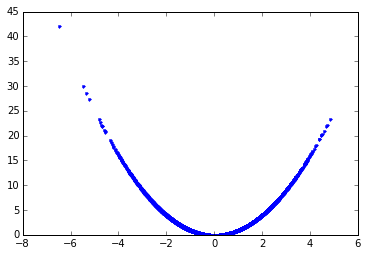

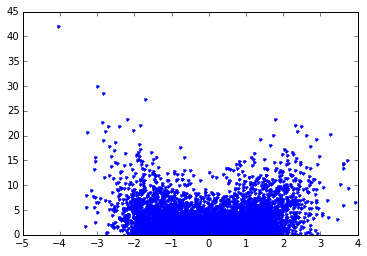

(10000, 3)


In [16]:
data = sample(10000)
plt.plot(data[:,0]-data[:,1],data[:,2],'b.')
plt.show()
plt.plot(data[:,0],data[:,2],'b.')
plt.show()

print data.shape

In [41]:
ENCODING = 6

invar = T.matrix()
nvar = T.matrix()

input = lasagne.layers.InputLayer((None,3), input_var = invar)
n_input = lasagne.layers.InputLayer((None, ENCODING), input_var = nvar)

# Standard auto-encoder

auto_d1 = lasagne.layers.DenseLayer(input, num_units = 128)
auto_enc = lasagne.layers.DenseLayer(auto_d1, num_units = ENCODING, nonlinearity = None)
auto_d2 = lasagne.layers.DenseLayer(auto_enc, num_units = 128)
auto_out = lasagne.layers.DenseLayer(auto_d2, num_units = 3, nonlinearity = None)

auto_code, auto_result = lasagne.layers.get_output([auto_enc, auto_out])
auto_params = lasagne.layers.get_all_params(auto_out, trainable = True)
auto_loss = T.mean( (auto_result - invar)**2 )
auto_reg = 0.03 * T.mean( (auto_code)**2 )
auto_updates = lasagne.updates.adam(auto_loss + auto_reg, auto_params, learning_rate = 1e-3)
auto_train = theano.function([invar], auto_loss, updates = auto_updates, allow_input_downcast = True)

auto_d2.input_layer = n_input
auto_gen = lasagne.layers.get_output(auto_out)
auto_generate = theano.function([nvar], auto_gen, allow_input_downcast = True)

# Variational auto-encoder

ELU = lasagne.nonlinearities.elu

vae_d1 = lasagne.layers.DenseLayer(input, num_units = 128)
vae_mu = lasagne.layers.DenseLayer(vae_d1, num_units = ENCODING, nonlinearity = None)
vae_sig = lasagne.layers.DenseLayer(vae_d1, num_units = ENCODING, nonlinearity = ELU)
vae_noise = lasagne.layers.ElemwiseMergeLayer([vae_sig, n_input], merge_function = T.mul)
vae_merge = lasagne.layers.ElemwiseSumLayer([vae_mu, vae_noise])
vae_d2 = lasagne.layers.DenseLayer(vae_merge, num_units = 128)
vae_out = lasagne.layers.DenseLayer(vae_d2, num_units = 3, nonlinearity = None)

vae_code_mu, vae_code_sigma, vae_result = lasagne.layers.get_output([vae_mu, vae_sig, vae_out])
vae_params = lasagne.layers.get_all_params(vae_out, trainable = True)
vae_loss = T.mean( (vae_result - invar)**2 )
vae_reg = 0.5*(T.mean(T.sum(vae_code_sigma**2 - T.log(vae_code_sigma**2+1e-16) + vae_code_mu**2,axis=1)))
vae_updates = lasagne.updates.adam(vae_loss + vae_reg, vae_params, learning_rate = 1e-3)
vae_train = theano.function([invar, nvar], vae_loss, updates = vae_updates, allow_input_downcast = True)

vae_d2.input_layer = n_input
vae_gen = lasagne.layers.get_output(vae_out)
vae_generate = theano.function([nvar], vae_gen, allow_input_downcast = True)

# Recurrent auto-encoder

rec_d1_1 = lasagne.layers.DenseLayer(input, num_units = 128)
rec_enc_1 = lasagne.layers.DenseLayer(rec_d1_1, num_units = ENCODING, nonlinearity = None)
rec_noise_1 = lasagne.layers.GaussianNoiseLayer(rec_enc_1, sigma = 0.1)
rec_d2_1 = lasagne.layers.DenseLayer(rec_noise_1, num_units = 128)
rec_out_1 = lasagne.layers.DenseLayer(rec_d2_1, num_units = 3, nonlinearity = None)

rec_d1_2 = lasagne.layers.DenseLayer(rec_out_1, num_units = 128, W = rec_d1_1.W, b = rec_d1_1.b)
rec_enc_2 = lasagne.layers.DenseLayer(rec_d1_2, num_units = ENCODING, nonlinearity = None, W = rec_enc_1.W, b = rec_enc_1.b)
rec_noise_2 = lasagne.layers.GaussianNoiseLayer(rec_enc_2, sigma = 0.1)
rec_d2_2 = lasagne.layers.DenseLayer(rec_noise_2, num_units = 128, W = rec_d2_1.W, b = rec_d2_1.b)
rec_out_2 = lasagne.layers.DenseLayer(rec_d2_2, num_units = 3, nonlinearity = None, W = rec_out_1.W, b = rec_out_1.b)

rec_d1_3 = lasagne.layers.DenseLayer(rec_out_2, num_units = 128, W = rec_d1_1.W, b = rec_d1_1.b)
rec_enc_3 = lasagne.layers.DenseLayer(rec_d1_3, num_units = ENCODING, nonlinearity = None, W = rec_enc_1.W, b = rec_enc_1.b)
rec_noise_3 = lasagne.layers.GaussianNoiseLayer(rec_enc_3, sigma = 0.1)
rec_d2_3 = lasagne.layers.DenseLayer(rec_noise_3, num_units = 128, W = rec_d2_1.W, b = rec_d2_1.b)
rec_out_3 = lasagne.layers.DenseLayer(rec_d2_3, num_units = 3, nonlinearity = None, W = rec_out_1.W, b = rec_out_1.b)

rec_code1, rec_code2, rec_code3, rec_result1, rec_result2, rec_result3 = lasagne.layers.get_output([rec_enc_1, rec_enc_2, rec_enc_3, rec_out_1, rec_out_2, rec_out_3])
rec_params = lasagne.layers.get_all_params(rec_out_3, trainable = True)
rec_loss = (1.0/3.0) * T.mean( (rec_result1 - invar)**2 + (rec_result2 - invar)**2 + (rec_result3 - invar)**2 )
rec_reg = (1.0/3.0) * 0.03 * T.mean( rec_code1**2 + rec_code2**2 + rec_code3**2 )

rec_updates = lasagne.updates.adam(rec_loss + rec_reg, rec_params, learning_rate = 1e-3)
rec_train = theano.function([invar], rec_loss, updates = rec_updates, allow_input_downcast = True)

rec_d2_1.input_layer = n_input
rec_gen = lasagne.layers.get_output(rec_out_3)
rec_generate = theano.function([nvar], rec_gen, allow_input_downcast = True)

In [42]:
ae_err = []
vae_err = []
rec_err = []

for epoch in range(800):
    ae_err.append(auto_train(data))
    vae_err.append(vae_train(data, np.random.randn(data.shape[0],ENCODING)))
    rec_err.append(rec_train(data))

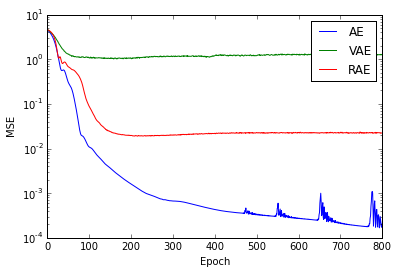

In [52]:
plt.plot(ae_err, 'b-', label="AE")
plt.plot(vae_err, 'g-', label="VAE")
plt.plot(rec_err, 'r-', label="RAE")
plt.legend()
plt.yscale("log")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.show()

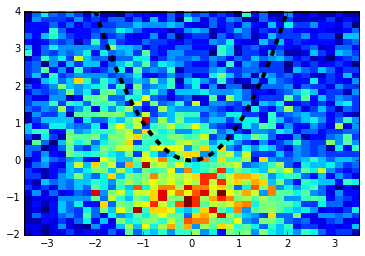

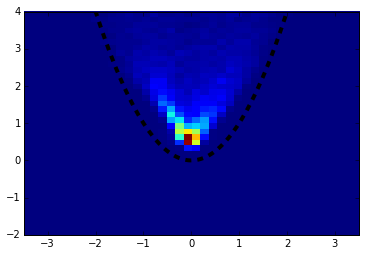

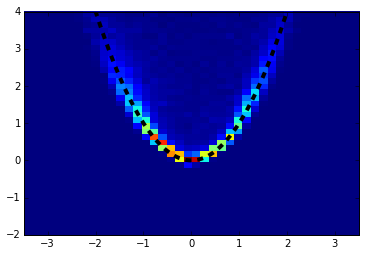

In [50]:
auto_fakes = auto_generate(np.random.randn(20000,ENCODING))
vae_fakes = vae_generate(np.random.randn(20000,ENCODING))
rec_fakes = rec_generate(np.random.randn(20000,ENCODING))

x = np.arange(-3.5,3.5,0.05)
#plt.plot(auto_fakes[:,0]-auto_fakes[:,1],auto_fakes[:,2],'b.')
plt.hist2d(auto_fakes[:,0]-auto_fakes[:,1],auto_fakes[:,2],40, range=((-3.5,3.5),(-2,4)))
plt.plot(x, x**2, 'k--', lw=4)
plt.xlim(-3.5,3.5)
plt.ylim(-2,4)
plt.show()

#plt.plot(vae_fakes[:,0]-vae_fakes[:,1],vae_fakes[:,2],'g.')
plt.hist2d(vae_fakes[:,0]-vae_fakes[:,1],vae_fakes[:,2],40, range=((-3.5,3.5),(-2,4)))
plt.plot(x, x**2, 'k--', lw=4)
plt.xlim(-3.5,3.5)
plt.ylim(-2,4)
plt.show()

#plt.plot(rec_fakes[:,0]-rec_fakes[:,1],rec_fakes[:,2],'r.')
plt.hist2d(rec_fakes[:,0]-rec_fakes[:,1],rec_fakes[:,2],40, range=((-3.5,3.5),(-2,4)))
plt.plot(x, x**2, 'k--', lw=4)
plt.xlim(-3.5,3.5)
plt.ylim(-2,4)
plt.show()


In [53]:
# Try pure Monte-Carlo resampling on regular AE

auto_project = theano.function([invar], auto_result, allow_input_downcast = True)

In [54]:
mc_1 = auto_project(auto_fakes)
mc_2 = auto_project(mc_1)

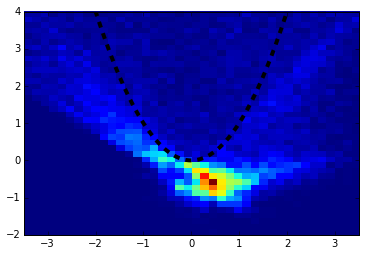

In [55]:
plt.hist2d(mc_2[:,0]-mc_2[:,1],mc_2[:,2],40, range=((-3.5,3.5),(-2,4)))
plt.plot(x, x**2, 'k--', lw=4)
plt.xlim(-3.5,3.5)
plt.ylim(-2,4)
plt.show()

In [56]:
mc_3 = auto_project(mc_2)
mc_4 = auto_project(mc_3)
mc_5 = auto_project(mc_4)

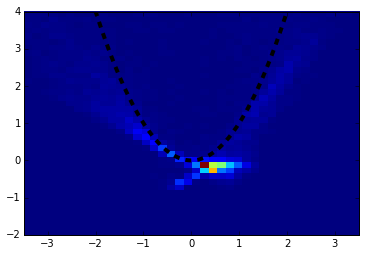

In [57]:
plt.hist2d(mc_5[:,0]-mc_5[:,1],mc_5[:,2],40, range=((-3.5,3.5),(-2,4)))
plt.plot(x, x**2, 'k--', lw=4)
plt.xlim(-3.5,3.5)
plt.ylim(-2,4)
plt.show()